In [1]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import re

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from string import punctuation

%matplotlib inline

In [2]:
# Раскомментируйте и скачайте эмбеддинги
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2022-10-07 21:18:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1,2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1,22G  21,1MB/s    in 61s     

2022-10-07 21:19:33 (20,5 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [350]:
#скачам также navec эмбеддинги
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!tar -xvf navec_hudlit_v1_12B_500K_300d_100q.tar

--2022-10-08 21:09:47--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50,56M  74,5MB/s    in 0,7s    

2022-10-08 21:09:48 (74,5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [2]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with open(file_path) as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
        max_words = vocab_size if max_words <= 0 else max_words

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [3]:
vocab, embeddings = load_embeddings('cc.ru.300.vec', max_words=100_000)

Reading embeddings file:   0%|          | 0/100000 [00:00<?, ?it/s]

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [4]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/home/nanosemantics/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/nanosemantics/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/nanosemantics/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


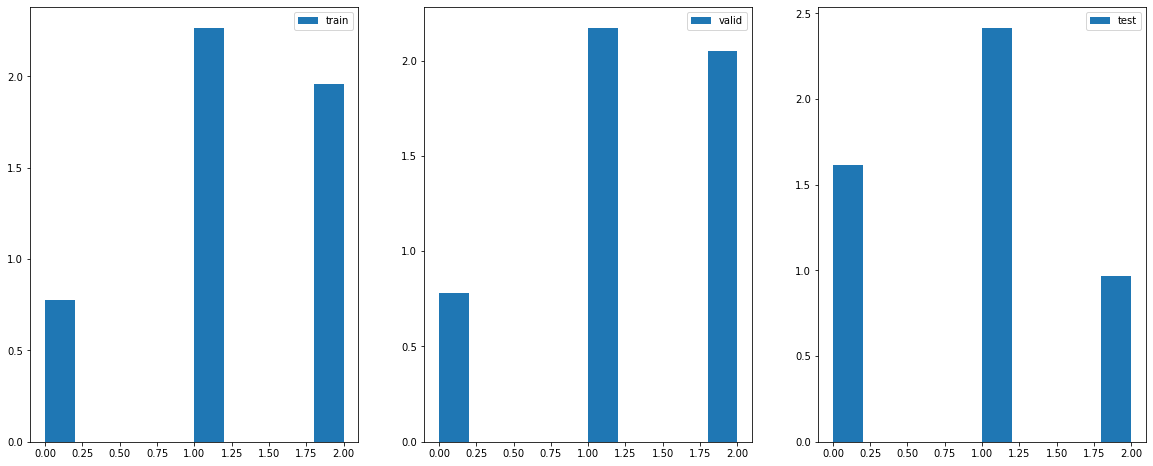

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))

axes[0].hist(train_dataset['label'], density=True, label='train')
axes[0].legend()

axes[1].hist(valid_dataset['label'], density=True, label='valid')
axes[1].legend()

axes[2].hist(test_dataset['label'], density=True, label='test')
axes[2].legend()

plt.show()

Баланс классов на тесте сильно отличается от того, что есть на трейне и валидации, это плохо, поэтому вероятнее всего на на тестовом датасете метрики будут отличаться от метрик на обучении.

Посмотрим на данные:

In [6]:
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
val_df = pd.DataFrame(valid_dataset)

In [7]:
train_df[train_df['label'] == 0]['text'].sample(10).values

array(['"\\""""Will you have lunch with me tomorrow night?\\""""-random hoe that\\u2019s hitting on Castle \\""""NOOOOOOOOO\\""""-Beckett"',
       'This is the 1st Halloween my kids didn\\u2019t go trick or treating... Kinda sad they are TOO OLD for it now cuz I...',
       '@user Akin and Murdoch are scum\\u002c but rape jokes aren\\u2019t much better brah.  They may just be just a (cont)',
       '@user These people CANNOT know who Mick Jagger is...you ain\\u2019t old\\u002c old skool maybe but c\\u2019mon! Mick Jagger has a lot more years than you!',
       '@user regardless of what he may say, a former boxer smashing UFC\'s biggest star last night was Dana White\'s worst nightmare"',
       '"The WWE may have fired Hulk Hogan, but it\'s still racist as hell via @user',
       "Gotta love the Rick Perry delusion ... God has tricked 'Tricky Ricky'.",
       '@user I\'m glad McCoy isn\'t on the Eagles anymore, he\'s such a hater. 1st he talked crap about Kelly now talking about Murra

In [8]:
train_df[train_df['label'] == 1]['text'].sample(10).values

array(['Imagine being De Gea going to sleep then waking up tomorrow ready to become a Real Madrid player',
       '#Pastors consider dedicating service on Sept 27 to praying for @user &amp;for Christians persecuted around the world',
       'I wish Ron Jaworski was still in the Monday Night Football booth. I enjoy Tirico and Gruden\\u002c I just think that Jaws offered a lot too.',
       '@user getting ready to go to da airforce in January, music, and workin basically about it....yhu still stay in Knollwood Apts. ?"',
       '"Muslim civil-rights group condemns Hamilton sheriff\'s remarks about Islam: On Monday, Hammond urged other Tenn...',
       '@user @user Miley &amp; Nicki staged it. Not only did NM break a smile, from the 2nd c-angle Miley says ""what"", before Nicki states topic"',
       'New Haven and Bentley will also face off next Friday night as both teams looks for their first win of the season.  #NE10',
       '"I may, however, decide to tweet about Big Brother using a 

In [9]:
train_df[train_df['label'] == 2]['text'].sample(10).values

array(["@user For when your working day eventually ends .... David Bowie 'Speed of Life' (off 'Low'). #Happy-Friday",
       '"It\'s Friday, and you should all have the riff from Iron Maiden\'s ""The Rime of the Ancient Mariner"" in your heads."',
       '@user @user just saw jennifer Hudson on 26th street she looks great!! Super skinny',
       "For all the fans outthere: Kurt Cobain's 1st band album poke @user",
       'Episode #31 of Minecraft just uploaded. I think the next episode I may go into the Nether.',
       '@user cant wait for tomorrow!!! see you at the kirby center!',
       '"David Price\'s 2nd pitcher of the week, Josh Donaldson\'s 2nd hitter of the week, Corey Kluber\'s 3rd pitcher of the day."',
       'This is all time greatest and why we all luv and hate Kanye west but he is a human that keeps the world alive #YE',
       "I apologize for my tweets I'm going to digi &amp; meeting all the baes tomorrow so I'm sorry in advance",
       "I'm a PDF convert. I shall see

In [10]:
class Tokenizer:
    
    def __init__(self, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = ToktokTokenizer()  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length
        
    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
#         tokens = self._base_tokenizer.tokenize(text)
        tokens = re.findall(r'\b[A-z]+\b', text)
        tokens = [token.lower().strip(punctuation) for token in tokens if token not in punctuation]
        return tokens
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        tokens_indices = []
        for token in tokenized_text:
            if token in self.token2index:
                idx = self.token2index[token]
                tokens_indices.append(idx)
            else:
                tokens_indices.append(self.unk_index)
        return tokens_indices
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        prev_idx = -1
        norep_tokens_indices = []

        for idx in tokens_indices:
            if idx != prev_idx:
                norep_tokens_indices.append(idx)
                prev_idx = idx
                
        if len(norep_tokens_indices) < self.max_length:
            norep_tokens_indices += [self.pad_index for _ in range(self.max_length - len(norep_tokens_indices))]
        elif len(norep_tokens_indices) > self.max_length:
            norep_tokens_indices = norep_tokens_indices[:self.max_length]
        return norep_tokens_indices
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужного размера (self.max_length)
        """
        tokens = self.tokenize(text)
        tokens_indices = self.indexing(tokens)
        padded_tokens_indices = self.padding(tokens_indices)
        return padded_tokens_indices
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        t = Tokenizer(self.token2index, self.pad_token, self.unk_token, self.max_length)
        for sample in batch:
            text, label = sample['text'], sample['label']
            tokenized_text = t(text)
            tokenized_texts.append(tokenized_text)
            labels.append(label)
            
        tokenized_texts = torch.tensor(tokenized_texts)
        labels = torch.tensor(labels)
        
        return tokenized_texts, labels

In [11]:
tokenizer = Tokenizer(token2index=vocab, pad_token='PAD', unk_token='UNK', max_length=64)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

In [12]:
for x, y in train_loader:
    break

In [13]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

## Выбор метрики
Я выбрал метрику f1 score с average='weighted', по той причине, что данная метрика подходит для оценки задач классификации и представляет собой среднее гармоническое значение между точностью и полнотой, а параметр average со значением weighted позволяет рассчитывать данную метрику с учетом количества (весов) представителей разных классов в датасете, а т.к. у нас дисбаланс классов, то это более объективная оценка.

In [58]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, embedding_dim, embeddings):
        super(DeepAverageNetwork, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32), padding_idx=0)
        self.linear_1 = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
        self.linear_2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
        self.batch_norm_1 = torch.nn.BatchNorm1d(self.embedding_dim // 2)
        self.batch_norm_2 = torch.nn.BatchNorm1d(self.embedding_dim // 4)
        self.clf_layer = nn.Linear(self.embedding_dim // 4, 3)
        self.activation = nn.Softmax(dim=1)
        
    def forward(self, x):
        emb = self.embedding(x)
        average_emb = emb.sum(axis=1) / (x != 0).sum(axis=1).unsqueeze(1)
        out_lin_1 = F.dropout(F.relu(self.batch_norm_1(self.linear_1(average_emb))), p=0.3)
        out_lin_2 = F.dropout(F.relu(self.batch_norm_2(self.linear_2(out_lin_1))), p=0.3)
        out_clf = self.clf_layer(out_lin_2)
        probs = self.activation(out_clf)
        return probs

In [59]:
#напишем функции обучения, теста, рисования графиков, confusion matrix

def train_model(model, train_loader, valid_loader, test_loader, n_epochs, optimizer, loss_func):
    
    NUM_EPOCHS = n_epochs  # Задайте количество эпох

    model.to(device)
    train_losses, validation_losses = [], []
    train_f1, val_f1 = [], []

    for n_epoch in tqdm(range(NUM_EPOCHS)):
        model.train()
        all_labels = np.empty(0)
        all_pred_labels = np.empty(0)
        for batch in train_loader:
            optimizer.zero_grad()
            batch = (t.to(device) for t in batch)
            ids, labels = batch
            pred_probs = model.forward(ids)
            pred_labels = pred_probs.argmax(axis=1).detach().cpu().numpy()
            loss = loss_func(pred_probs, labels)
            labels = labels.detach().cpu().numpy()
            all_labels = np.hstack([all_labels, labels])
            all_pred_labels = np.hstack([all_pred_labels, pred_labels])
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        epoch_train_f1 = f1_score(all_labels, all_pred_labels, average='weighted')
        train_f1.append(epoch_train_f1)

        all_labels = np.empty(0)
        all_pred_labels = np.empty(0)

        model.eval()
        for batch in valid_loader:
            batch = (t.to(device) for t in batch)
            ids, labels = batch
            with torch.no_grad():
                pred_probs = model.forward(ids)
            pred_labels = pred_probs.argmax(axis=1).detach().cpu().numpy()
            loss = loss_func(pred_probs, labels)
            labels = labels.detach().cpu().numpy()
            all_labels = np.hstack([all_labels, labels])
            all_pred_labels = np.hstack([all_pred_labels, pred_labels])
            validation_losses.append(loss.item())

        epoch_val_f1 = f1_score(all_labels, all_pred_labels, average='weighted')
        print(f'Epoch {n_epoch + 1} ... train f1 score {epoch_train_f1:.2f} ... validation f1 score {epoch_val_f1:.2f} ... train loss {np.mean(train_losses[-len(train_loader):]):.2f} ... val loss {np.mean(validation_losses[-len(valid_loader):]):.2f}')
        print('-' * 120)
        val_f1.append(epoch_val_f1)
        
    test_model(model, test_loader, loss_func)
    plot_metrics(train_losses, validation_losses, train_f1, val_f1)
    return model
    
def test_model(model, test_loader, loss_func):
    all_labels = np.empty(0)
    all_pred_labels = np.empty(0)
    test_losses = []

    model.eval()
    for batch in test_loader:
        batch = (t.to(device) for t in batch)
        ids, labels = batch
        with torch.no_grad():
            pred_probs = model.forward(ids)
        pred_labels = pred_probs.argmax(axis=1).detach().cpu().numpy()
        loss = loss_func(pred_probs, labels)
        labels = labels.detach().cpu().numpy()
        all_labels = np.hstack([all_labels, labels])
        all_pred_labels = np.hstack([all_pred_labels, pred_labels])
        test_losses.append(loss.item())
    
    test_f1 = f1_score(all_labels, all_pred_labels, average='weighted')
    print(f'test f1 score {test_f1:.2f} ... test loss {np.mean(test_losses):.2f}')
    print('-' * 120)
    print(classification_report(all_labels, all_pred_labels, ))
    plot_confusion_matrix(all_labels, all_pred_labels)
    
def plot_metrics(train_losses, validation_losses, train_f1, val_f1):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    axes[0][0].plot(train_losses, label='train loss')
    axes[0][0].legend()

    axes[0][1].plot(validation_losses, label='validation loss')
    axes[0][1].legend()

    axes[1][0].plot(train_f1, label='train f1 score')
    axes[1][0].legend()

    axes[1][1].plot(val_f1, label='val f1 score')
    axes[1][1].legend()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 ... train f1 score 0.44 ... validation f1 score 0.44 ... train loss 1.06 ... val loss 1.03
------------------------------------------------------------------------------------------------------------------------
Epoch 2 ... train f1 score 0.47 ... validation f1 score 0.47 ... train loss 1.02 ... val loss 1.02
------------------------------------------------------------------------------------------------------------------------
Epoch 3 ... train f1 score 0.48 ... validation f1 score 0.48 ... train loss 1.00 ... val loss 1.01
------------------------------------------------------------------------------------------------------------------------
Epoch 4 ... train f1 score 0.49 ... validation f1 score 0.48 ... train loss 0.99 ... val loss 1.00
------------------------------------------------------------------------------------------------------------------------
Epoch 5 ... train f1 score 0.49 ... validation f1 score 0.48 ... train loss 0.99 ... val loss 1.00
---------------------

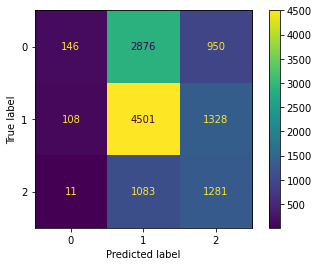

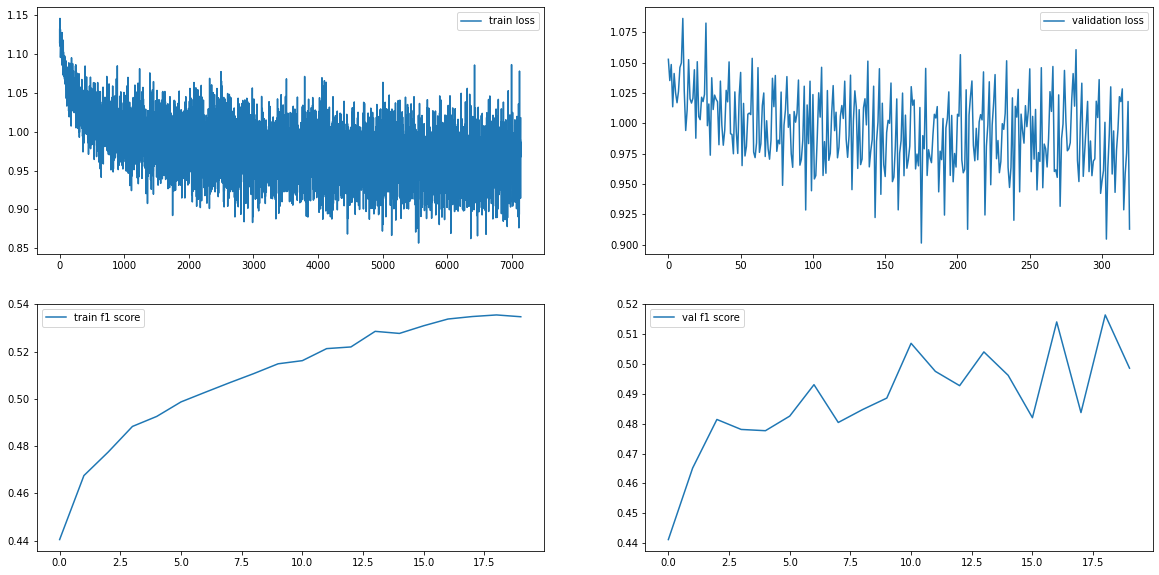

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DeepAverageNetwork(300, embeddings)
lr = 1e-4
n_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
ce_loss = torch.nn.CrossEntropyLoss()

trained_model = train_model(model, train_loader, valid_loader, test_loader, n_epochs, optimizer, ce_loss)

Модель не переобучилась, лосс на валидации и трейне не растет.

Качество получилось очень низкое, вероятнее всего проблема либо в слабой архитектуре, либо в использованных эмбеддингах. Попробуем использовать эмбеддинги получше, из библиотеки Navec.

In [61]:
class DeepAverageNetworkNavec(nn.Module):
    def __init__(self, embedding_dim, navec_embeddings):
        super(DeepAverageNetworkNavec, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = NavecEmbedding(navec_embeddings)
        self.linear_1 = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
        self.linear_2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
        self.batch_norm_1 = torch.nn.BatchNorm1d(self.embedding_dim // 2)
        self.batch_norm_2 = torch.nn.BatchNorm1d(self.embedding_dim // 4)
        self.clf_layer = nn.Linear(self.embedding_dim // 4, 3)
        self.activation = nn.Softmax(dim=1)
        
    def forward(self, x):
        emb = self.embedding(x)
        average_emb = emb.sum(axis=1) / (x != 0).sum(axis=1).unsqueeze(1)
        out_lin_1 = F.dropout(F.relu(self.batch_norm_1(self.linear_1(average_emb))), p=0.3)
        out_lin_2 = F.dropout(F.relu(self.batch_norm_2(self.linear_2(out_lin_1))), p=0.3)
        out_clf = self.clf_layer(out_lin_2)
        probs = self.activation(out_clf)
        return probs

In [62]:
from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

def create_vocab_from_navec(navec):
    navec = Navec.load(path)
    return {word:navec.vocab[word] for word in navec.vocab.words}       

In [63]:
token2index = create_vocab_from_navec(path)

tokenizer = Tokenizer(token2index=token2index, pad_token='<pad>', unk_token='<unk>', max_length=128)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

In [64]:
from transformers import Adafactor

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 ... train f1 score 0.47 ... validation f1 score 0.49 ... train loss 1.05 ... val loss 1.02
------------------------------------------------------------------------------------------------------------------------
Epoch 2 ... train f1 score 0.52 ... validation f1 score 0.51 ... train loss 0.98 ... val loss 0.98
------------------------------------------------------------------------------------------------------------------------
Epoch 3 ... train f1 score 0.54 ... validation f1 score 0.53 ... train loss 0.96 ... val loss 0.97
------------------------------------------------------------------------------------------------------------------------
Epoch 4 ... train f1 score 0.55 ... validation f1 score 0.55 ... train loss 0.95 ... val loss 0.96
------------------------------------------------------------------------------------------------------------------------
Epoch 5 ... train f1 score 0.57 ... validation f1 score 0.55 ... train loss 0.94 ... val loss 0.95
---------------------

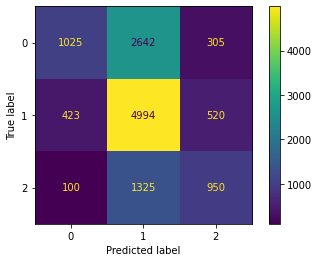

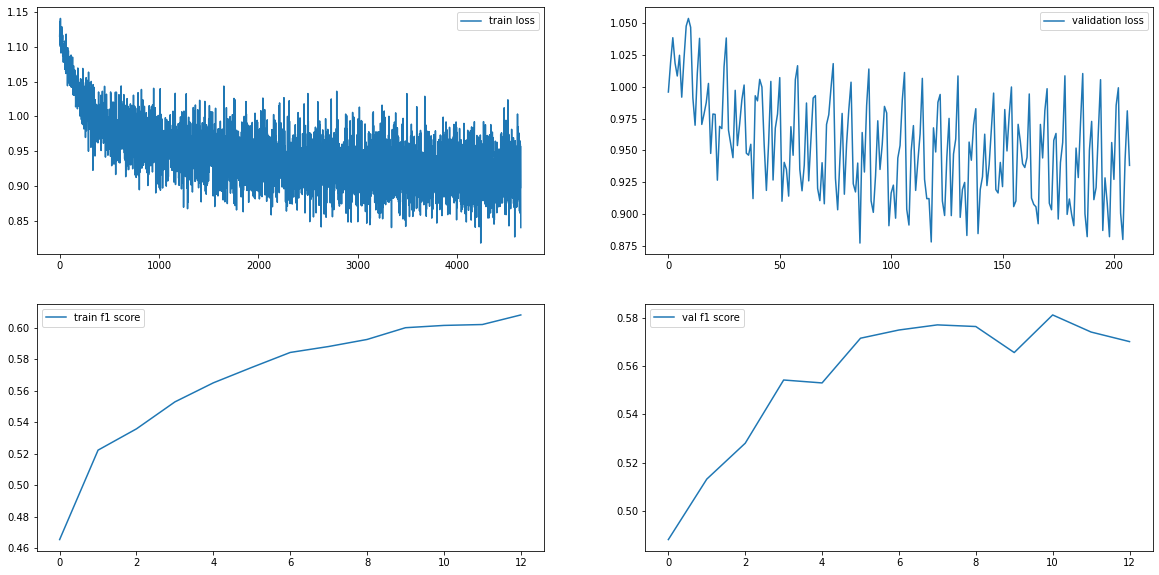

In [67]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
navec_embs = Navec.load(path)
model = DeepAverageNetworkNavec(300, navec_embs)
lr = 1e-4
n_epochs = 13
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = Adafactor(model.parameters())
ce_loss = torch.nn.CrossEntropyLoss()

trained_model = train_model(model, train_loader, valid_loader, test_loader, n_epochs, optimizer, ce_loss)

## Выводы

Данная модель лучше, чем предыдущая на Fasttext эмбеддингах, но качество все равно никуда не годится. Переобучилась если только совсем немного на последних двух эпохах, но это не критично, учитывая тот факт что для продакшена такая модель все равно не подходит. 

Модель больше всего ошибается на нейтральных примерах (по графику confusion matrix), т.е. не находит разницы между между нейтральными и позитивными/отрицательными примерами - это действительно сложно. Это происходит по той причине, что в данных твитов есть множество слов, которые не содержатся в словарях эмбеддингов, а мы для этих слов задаем токен UNK, хотя они по факту являются наиболее определяющими для определения тональности, по типу Fuckkk, kakkest, haha и т.д. Плюс я выкидываю знаки препинания из предобработки, что плохо для подобных задач, т.к. они также могут нести в себе смысл сентимента.

Также проблема низкого качества моделей заключается в том, что DAN архитектура модели слишком слабая для подобной задачи, даже для бейзлайна она не подходит. Выше качество удалось бы добиться с использованием хотя бы LSTM или моделей на архитектуре трансформеров. Плюсом использования трансформеров является то, что они имеют в своих весах знания о языке, а токенизатор sentence piece позволяет обрабатывать более редкие слова и иметь представления в виде эмбеддингов для них. Использовать трансформеры в этой задаче мне было уже лень, но вот пример использования трансформенной модели обученной на 7 фолдах для задачи классификации текстов обращений: https://github.com/tumanov-a/kursk_ml/blob/main/train_model.ipynb